In [13]:
# This is a hidden cell which will be executed but will not show up in Sphinx docs.
# To hide a cell, in Jupyter go to Menu->View->Cell Toolbar->Edit Metadata
# and enter in {"nbsphinx": "hidden"}

# Set figure size and font size
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['font.size'] = 12

# Understanding references

In this tutorial we'll investigate what "references" are.  The GDSII specification allows the use of references, and similarly PHIDL uses them (with the `add_ref()` function).  So what is a reference? Simply put:  **A reference does not contain any geometry. It only *points* to an existing geometry**.  That still might not be clear, so let's use an example:

Say Alice has a ridiculously large polygon with 100 billion vertices in it that we'll call BigPolygon.  It's huge, but she needs to use it in her design 250 times.  Well, a single copy of BigPolygon takes up 100GB of memory just by itself, so she doesn't want to make 250 copies of it. Since Alice is clever, she instead *references* the polygon 250 times.  Each reference only uses a few bytes of memory -- it only needs to know the memory address of BigPolygon and a few other things. In this way, she can keep one copy of BigPolygon and use it again and again wherever she needs to.

If that's still not clear, let's use the following examples.

## Using references

Let's start by making a blank geometry (`Device`) then adding a single polygon to it.

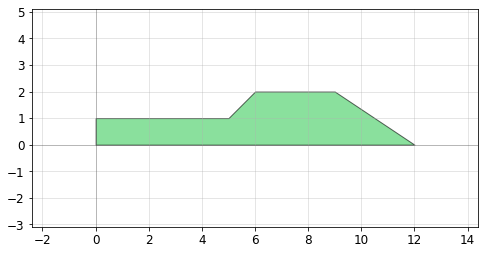

In [14]:
import numpy as np
import phidl.geometry as pg
from phidl import Device
from phidl import quickplot as qp


# Create a blank Device
P = Device()

# Add a polygon
xpts = [0,0,5,6,9,12]
ypts = [0,1,1,2,2,0]
P.add_polygon([xpts,ypts])

# Quickplot the Device with the polygon in it
qp(P)

Now, pretend we're in the same position as Alice: We want to reuse this polygon repeatedly but do not want to make multiple copies of it.  To do so, we need to make a second blank `Device`, this time called `D`.  In this new Device we'll *reference* our Device `P` which contains our polygon.

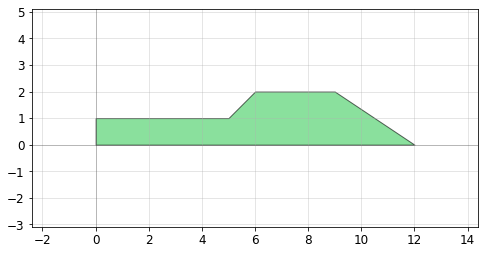

In [15]:
D = Device()             # Create a new blank Device
poly_ref = D.add_ref(P)  # Reference the Device "P" that has the polygon in it

qp(D) # Quickplot the reference-containing device "D"

OK, well that seemed to work, but it also seems thoroughly useless!  It looks like we just made a copy of our polygon -- but remember, we've didn't actually make a second polygon, we just made a reference (aka pointer) to the original polygon.  Let's continue with the example by adding two more references to `D`:

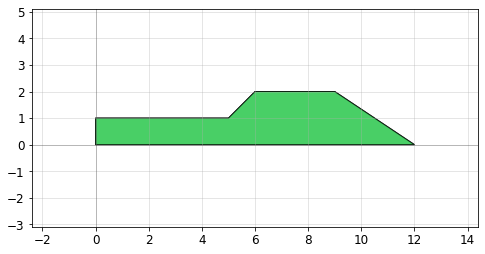

In [16]:
poly_ref2 = D.add_ref(P)  # Reference the Device "P" that has the polygon in it
poly_ref3 = D.add_ref(P)  # Reference the Device "P" that has the polygon in it

qp(D) # Quickplot the reference-containing device "D"

Now we have 3x polygons all on top of each other.  Again, this would appear useless, except that we can manipulate each reference indepedently. Notice that when we called `D.add_ref(P)` above, we saved the result to a new variable each time (`poly_ref`, `poly_ref2`, and `poly_ref3`)?  We can use those variables to reposition the references.  Let's try:

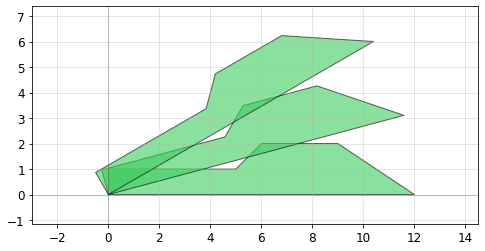

In [17]:
poly_ref2.rotate(15) # Rotate the 2nd reference we made 15 degrees
poly_ref3.rotate(30) # Rotate the 3rd reference we made 30 degrees

qp(D) # Quickplot the reference-containing device "D"

Now we're getting somewhere!  We've only had to make the polygon once, but we're able to reuse it as many times as we want.

## Modifying the referenced geometry

Now, a question naturally follows this:  What happens when you change the original geometry that the reference points to?  In our case, our references in `D` all point to the Device `P` that with the original polygon.  Let's try adding a second polygon to `P`.

First we add the second polygon and make sure `P` looks like we expect:

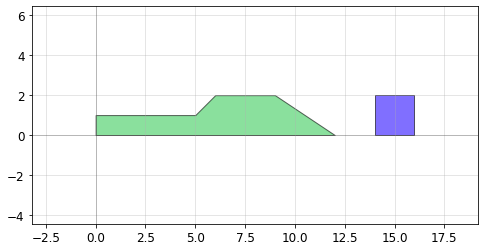

In [18]:
# Add a 2nd polygon to "P"
xpts = [14,14,16,16]
ypts = [0,2,2,0]
P.add_polygon([xpts,ypts], layer = 1)

qp(P) # Quickplot the "P" with its 2 polygons

That looks good.  Now let's find out what happened to `D` that contains the three references.  Keep in mind that we have not modified `D` or executed any functions/operations on `D` -- all we have done is modify `P`.

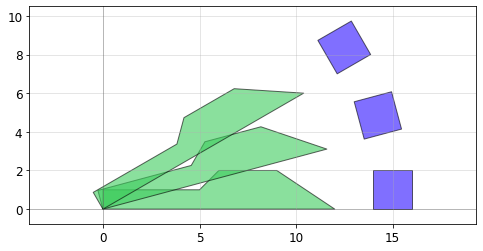

In [19]:
qp(D)  # Quickplot the reference-containing device "D"

We have our answer!  **When we modify the original geometry, all of the references automatically reflect the modifications.**  This is very powerful, because we can use this to make very complicated designs from relatively simple elements in a computation- and memory-efficienct way.

Let's try making references a level deeper by referencing `D`.  Note here we use the `<<` operator to add the references -- this is just shorthand, and is exactly equivalent to using `add_ref()`

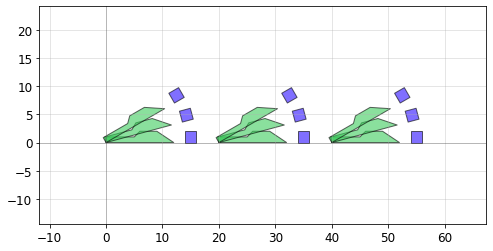

In [20]:
X = Device()             # Create a new blank Device
d_ref1 = X.add_ref(D)  # Reference the Device "D" that 3 references in it
d_ref2 = X << D        # Use the "<<" operator to create a 2nd reference to Dit
d_ref3 = X << D        # Use the "<<" operator to create a 2nd reference to D

d_ref1.move([20,0])
d_ref2.move([40,0])

qp(X) # Quickplot the reference-containing device "D"

## Arrays of references

Sometimes it's convenient to make an array or grid of the same geometry.  For that purpose, the GDSII spec allows you to define arrays of references.  In PHIDL, these are added with the `add_array()` function. Note that by GDSII definition these arrays are on a fixed grid -- PHIDL does however have more flexible arrangement options if desired, see for example `grid()` and `packer()`.

Let's make a new device and put a big array of our Device `D` in it:

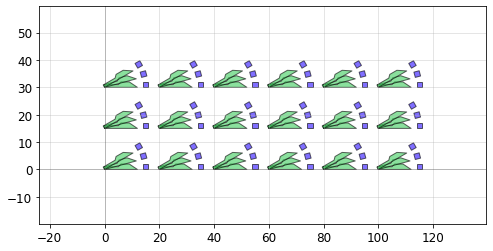

In [21]:
A = Device()           # Create a new blank Device
d_ref1 = A.add_array(D, columns = 6, rows = 3, spacing = [20,15])  # Reference the Device "D" that 3 references in it

qp(A) # Quickplot the reference-containing device "D"